<a href="https://colab.research.google.com/github/Chthanh/Sentiment-Analysis-for-Financial-News/blob/main/Financial_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

drive  sample_data


In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis

/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis


In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
!wget -O dataset.zip "https://drive.google.com/uc?export=download&id=1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg"

--2023-11-28 06:49:27--  https://drive.google.com/uc?export=download&id=1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg
Resolving drive.google.com (drive.google.com)... 142.251.172.101, 142.251.172.100, 142.251.172.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.172.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h0o9itqbu703doavbb1rs4hopeh0nm8g/1701154125000/16346474942041582373/*/1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg?e=download&uuid=5d50c4ae-3266-4962-9dd1-cd7115d439b0 [following]
--2023-11-28 06:49:27--  https://doc-00-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h0o9itqbu703doavbb1rs4hopeh0nm8g/1701154125000/16346474942041582373/*/1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg?e=download&uuid=5d50c4ae-3266-4962-9dd1-cd7115d439b0
Resolving doc-00-8s-docs.googleusercontent.com (doc-00-8s-docs.googleusercontent.com)... 64.233.181.132, 2

In [ ]:
!gdown 1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg

Downloading...
From: https://drive.google.com/uc?id=1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg
To: /content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/financial_sentiment.zip
100% 925k/925k [00:00<00:00, 113MB/s]


In [ ]:
!unzip financial_sentiment.zip

Archive:  financial_sentiment.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


In [4]:
dataset_path = 'all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    dataset_path,
    names = headers,
    encoding = 'ISO-8859-1'
)

In [5]:
df.head(5)

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [6]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

In [7]:
classes

{'neutral': 0, 'negative': 1, 'positive': 2}

In [8]:
#data preprocessing
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  text = re.sub(r'[^\w\s]', '', text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

  return text

In [9]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [10]:
#building vocabulary
vocab = []
for sentence in df['content'].tolist():
  tokens = sentence.split()
  for token in tokens:
    if token not in vocab:
      vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [11]:
def transform(text, word_to_idx, max_seq_len):
  tokens = []
  for w in text.split():
    try:
      w_ids = word_to_idx[w]
    except:
      w_ids = word_to_idx['UNK']
    tokens.append(w_ids)

  if len(tokens) < max_seq_len:
    tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
  elif len(tokens) > max_seq_len:
    tokens = tokens[:max_seq_len]

  return tokens

In [12]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size = val_size,
    random_state = seed,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels,
    test_size = val_size,
    random_state = seed,
    shuffle = is_shuffle
)

In [13]:
class FinancialNews(Dataset):
  def __init__(self, X, y, word_to_idx, max_seq_len, transform = None):
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    if self.transform:
      text = self.transform(text, self.word_to_idx, self.max_seq_len)

    text = torch.tensor(text)

    return text, label

In [14]:
max_seq_len = 32

train_dataset = FinancialNews(X_train, y_train, word_to_idx = word_to_idx, max_seq_len = max_seq_len, transform = transform)
val_dataset = FinancialNews(X_val, y_val, word_to_idx = word_to_idx, max_seq_len = max_seq_len, transform = transform)
test_dataset = FinancialNews(X_test, y_test, word_to_idx = word_to_idx, max_seq_len = max_seq_len, transform = transform)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = test_batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True)

In [15]:
# Using RNN
class SentimentClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
    super(SentimentClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first = True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn. ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [ ]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    n_layers = n_layers,
    n_classes = n_classes,
    dropout_prob = dropout_prob
).to(device)

In [20]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = lr
)

In [21]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

In [22]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal_loss: {val_loss:.4f}')

  return train_losses, val_losses

In [ ]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1:	Train loss: 0.9968	Val_loss: 0.9499
EPOCH 2:	Train loss: 0.9385	Val_loss: 0.9353
EPOCH 3:	Train loss: 0.9304	Val_loss: 0.9335
EPOCH 4:	Train loss: 0.9299	Val_loss: 0.9286
EPOCH 5:	Train loss: 0.9290	Val_loss: 0.9335
EPOCH 6:	Train loss: 0.9288	Val_loss: 0.9350
EPOCH 7:	Train loss: 0.9247	Val_loss: 0.9289
EPOCH 8:	Train loss: 0.9301	Val_loss: 0.9286
EPOCH 9:	Train loss: 0.9304	Val_loss: 0.9307
EPOCH 10:	Train loss: 0.9285	Val_loss: 0.9304
EPOCH 11:	Train loss: 0.9293	Val_loss: 0.9281
EPOCH 12:	Train loss: 0.9264	Val_loss: 0.9280
EPOCH 13:	Train loss: 0.9283	Val_loss: 0.9309
EPOCH 14:	Train loss: 0.9243	Val_loss: 0.9281
EPOCH 15:	Train loss: 0.9270	Val_loss: 0.9279
EPOCH 16:	Train loss: 0.9287	Val_loss: 0.9281
EPOCH 17:	Train loss: 0.9242	Val_loss: 0.9279
EPOCH 18:	Train loss: 0.9259	Val_loss: 0.9278
EPOCH 19:	Train loss: 0.9263	Val_loss: 0.9348
EPOCH 20:	Train loss: 0.9267	Val_loss: 0.9301
EPOCH 21:	Train loss: 0.9250	Val_loss: 0.9278
EPOCH 22:	Train loss: 0.9226	Val_loss: 0.93

In [ ]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

In [ ]:
print('Evaluate on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluate on val/test dataset
Val accuracy:  0.6123711340206186
Test accuracy:  0.6123711340206186


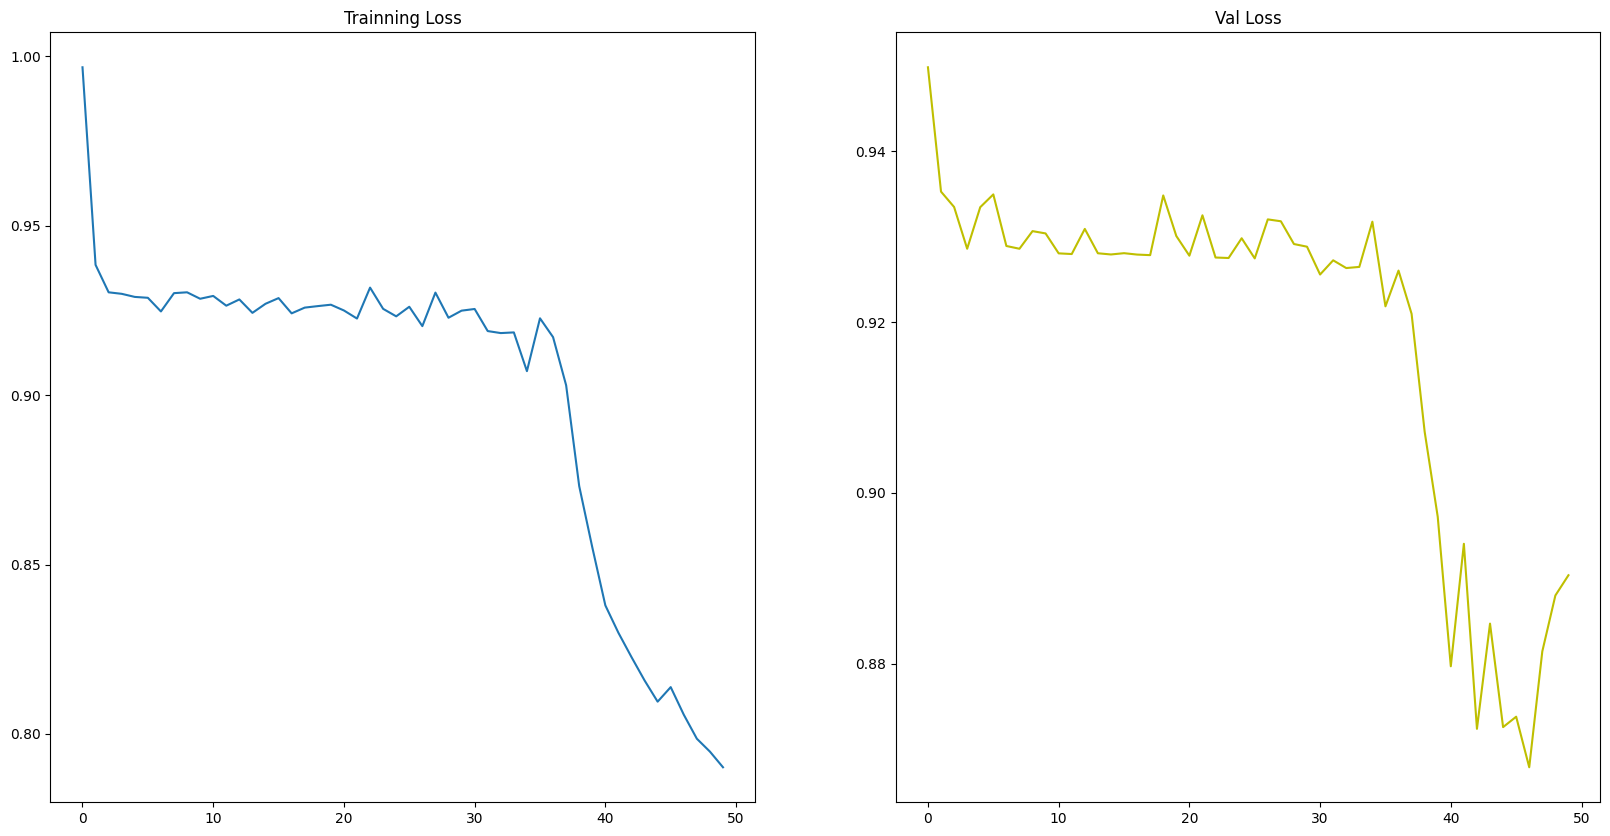

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.title('Trainning Loss')
plt.plot(train_losses)

plt.subplot(122)
plt.title('Val Loss')
plt.plot(val_losses, 'y')

In [ ]:
next(iter(test_loader))

[tensor([[  35,   43,  218,  219,  916,   45, 1569, 1722,    6, 1723, 1299,  808,
             5,   48,  290,  265,  641, 8907, 8907, 8907, 8907, 8907, 8907, 8907,
          8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907],
         [1256,   40, 3163, 1474, 6512, 8907, 8907, 8907, 8907, 8907, 8907, 8907,
          8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907,
          8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907],
         [2534, 2535, 1659,  262, 2536, 2537,  515,   53, 2538, 2077, 2539,  957,
          2335, 2540,   10, 2488,    5, 1888, 8907, 8907, 8907, 8907, 8907, 8907,
          8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907],
         [ 915,  334,  298,  388,   59, 1105, 1390, 1353, 1394,  269, 8907, 8907,
          8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907,
          8907, 8907, 8907, 8907, 8907, 8907, 8907, 8907],
         [ 287, 8186, 8567, 4018, 4153, 3855, 1664, 6842, 3107, 2923, 1397, 8907,
          8907, 8907, 8907

In [ ]:
input = """With the new production plant the company would increase its capacity to meet
the expected increase in demand and would improve the use of raw materials
and therefore increase the production profitability ."""
input = text_normalize(input)
input = transform(input, word_to_idx, max_seq_len)
input = torch.tensor(input)
input = input.unsqueeze(0)

In [ ]:
result = np.argmax(model(input).detach().numpy())
result

2

In [ ]:
classes

{'neutral': 0, 'negative': 1, 'positive': 2}

In [18]:
# Using LSTM
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.LSTM(embedding_dim, hidden_size, n_layers, batch_first = True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn. ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [19]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTMModel(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    hidden_size = hidden_size,
    n_layers = n_layers,
    n_classes = n_classes,
    dropout_prob = dropout_prob
).to(device)

In [23]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1:	Train loss: 0.9422	Val_loss: 0.9293
EPOCH 2:	Train loss: 0.9283	Val_loss: 0.9293
EPOCH 3:	Train loss: 0.9304	Val_loss: 0.9291
EPOCH 4:	Train loss: 0.9246	Val_loss: 0.9317
EPOCH 5:	Train loss: 0.9290	Val_loss: 0.9290
EPOCH 6:	Train loss: 0.9307	Val_loss: 0.9264
EPOCH 7:	Train loss: 0.9275	Val_loss: 0.9263
EPOCH 8:	Train loss: 0.9241	Val_loss: 0.9286
EPOCH 9:	Train loss: 0.9257	Val_loss: 0.9275
EPOCH 10:	Train loss: 0.9238	Val_loss: 0.9301
EPOCH 11:	Train loss: 0.9265	Val_loss: 0.9325
EPOCH 12:	Train loss: 0.9247	Val_loss: 0.9293
EPOCH 13:	Train loss: 0.9214	Val_loss: 0.9248
EPOCH 14:	Train loss: 0.9266	Val_loss: 0.9302
EPOCH 15:	Train loss: 0.9205	Val_loss: 0.9276
EPOCH 16:	Train loss: 0.9203	Val_loss: 0.9244
EPOCH 17:	Train loss: 0.9201	Val_loss: 0.9223
EPOCH 18:	Train loss: 0.9142	Val_loss: 0.9163
EPOCH 19:	Train loss: 0.8982	Val_loss: 0.8975
EPOCH 20:	Train loss: 0.8880	Val_loss: 0.8905
EPOCH 21:	Train loss: 0.8751	Val_loss: 0.8889
EPOCH 22:	Train loss: 0.8547	Val_loss: 0.88

In [24]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

In [25]:
print('Evaluate on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluate on val/test dataset
Val accuracy:  0.6288659793814433
Test accuracy:  0.6288659793814433


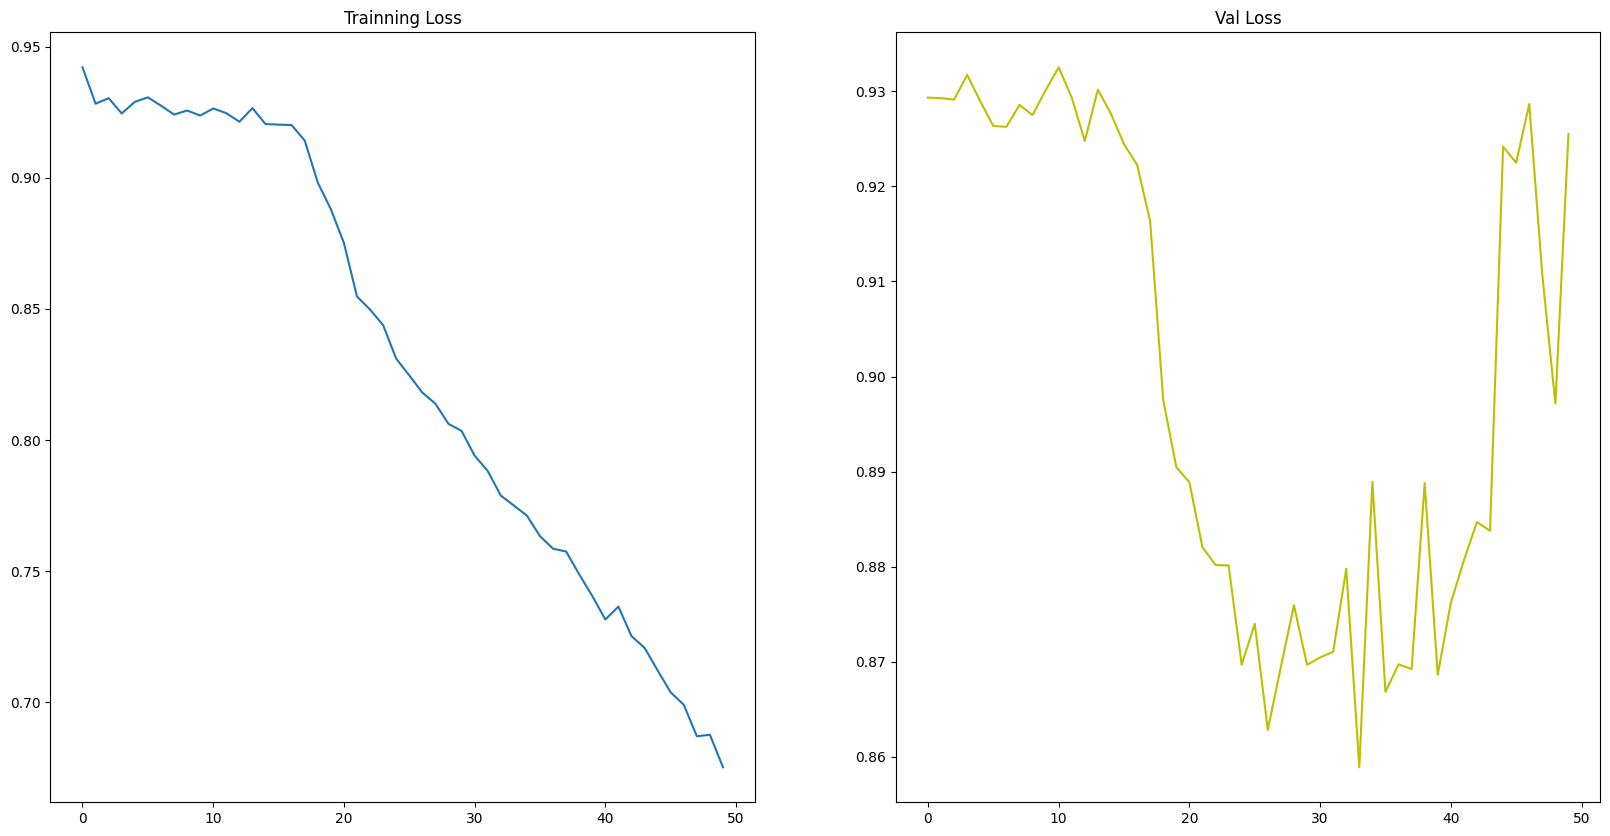

In [26]:
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.title('Trainning Loss')
plt.plot(train_losses)

plt.subplot(122)
plt.title('Val Loss')
plt.plot(val_losses, 'y')

In [27]:
input = """With the new production plant the company would increase its capacity to meet
the expected increase in demand and would improve the use of raw materials
and therefore increase the production profitability ."""
input = text_normalize(input)
input = transform(input, word_to_idx, max_seq_len)
input = torch.tensor(input)
input = input.unsqueeze(0)

In [28]:
result = np.argmax(model(input).detach().numpy())
result

2